In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [54]:
equity = pd.read_csv("equity_net_series.csv", index_col=0, parse_dates=True)
if isinstance(equity, pd.DataFrame) and equity.shape[1] == 1:
    equity = equity.iloc[:,0]

# Performance metrics

In [57]:
# total return (decimal)
total_ret = float(equity.iloc[-1])

In [59]:
# horizon in years
years = (equity.index[-1] - equity.index[0]).days / 365

In [61]:
# CAGR
cagr = (1 + total_ret)**(1/years) - 1 if years > 0 else np.nan

In [63]:
# daily strategy returns - from equity
daily_ret = equity.diff().fillna(0)

In [65]:
# annualized volatility (for 252 trading days)
ann_vol = daily_ret.std() * np.sqrt(252)

In [67]:
# annualized return 
ann_ret = daily_ret.mean() * 252

In [69]:
# sharpe
sharpe = ann_ret / ann_vol if ann_vol != 0 else np.nan

In [71]:
# max drawdown
cummax = equity.cummax()
drawdown = equity - cummax
max_dd = drawdown.min()
dd_pct = (max_dd / cummax.max()) if cummax.max() != 0 else np.nan

In [75]:
print("Performance summary")
print("-------------------")
print(f"Total return (decimal): {total_ret:.4f}")
print(f"Years: {years:.2f}")
print(f"CAGR: {cagr:.4%}")
print(f"Annualized return (from daily mean): {ann_ret:.4%}")
print(f"Annualized vol: {ann_vol:.4%}")
print(f"Sharpe: {sharpe:.2f}")
print(f"Max drawdown (absolute): {max_dd:.4f}")
print(f"Max drawdown (as % of peak): {dd_pct:.2%}")

Performance summary
-------------------
Total return (decimal): 0.6361
Years: 7.01
CAGR: 7.2802%
Annualized return (from daily mean): 9.2654%
Annualized vol: 14.8146%
Sharpe: 0.63
Max drawdown (absolute): -0.2594
Max drawdown (as % of peak): -40.29%


# Trade Log

In [82]:
from datetime import timedelta
import os

In [84]:
adj_file = "hdfc_icici_adjclose_clean.csv"
pos_file = "pos_series.csv"

if not os.path.exists(adj_file):
    raise FileNotFoundError(f"{adj_file} not found. Run s2_backtest and save prices.")


In [88]:
adj = pd.read_csv(adj_file, index_col=0, parse_dates=True)
# pos might be a series or df
if os.path.exists(pos_file):
    pos = pd.read_csv(pos_file, index_col=0, parse_dates=True)
    if isinstance(pos, pd.DataFrame) and pos.shape[1] == 1:
        pos = pos.iloc[:,0]
else:
    raise FileNotFoundError(f"{pos_file} not found. Save pos from s2_backtest.")

In [90]:
adj.columns = [c if ("HDFCBANK" in str(c) or "ICICIBANK" in str(c)) else ("HDFCBANK.NS" if i==0 else "ICICIBANK.NS")
               for i,c in enumerate(adj.columns)]
lookback = 30
ratio = adj['HDFCBANK.NS'] / adj['ICICIBANK.NS']
mean = ratio.rolling(lookback).mean()
std = ratio.rolling(lookback).std()
z = (ratio - mean) / std

In [96]:
pos = pos.reindex(ratio.index).fillna(method='ffill').fillna(0).astype(int)

changes = pos.diff().fillna(0)
change_idx = changes[changes != 0].index

trades = []
entry = None

/tmp/ipykernel_4079/3906893838.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pos = pos.reindex(ratio.index).fillna(method='ffill').fillna(0).astype(int)


In [98]:
for t in change_idx:
    change = int(changes.loc[t])
    prev = pos.loc[t - timedelta(days=1)] if (t - timedelta(days=1)) in pos.index else 0
    # If prev==0 and change !=0 -> entry at t
    if prev == 0 and change != 0:
        entry = {
            'entry_date': t,
            'entry_pos': int(pos.loc[t]),
            'entry_price_H': float(adj.loc[t, 'HDFCBANK.NS']),
            'entry_price_I': float(adj.loc[t, 'ICICIBANK.NS']),
            'entry_z': float(z.loc[t])
        }
    # If prev != 0 and change == -prev -> exit at t (closing)
    elif prev != 0 and change == -prev:
        if entry is None:
            # unexpected: an exit without stored entry; skip
            continue
        exit = {
            'exit_date': t,
            'exit_pos': 0,
            'exit_price_H': float(adj.loc[t, 'HDFCBANK.NS']),
            'exit_price_I': float(adj.loc[t, 'ICICIBANK.NS']),
            'exit_z': float(z.loc[t])
        }
        # compute PnL for the round-trip (per-unit, unlevered)
        # For a long-ratio entry (entry_pos==1): PnL = (P_H_exit/P_H_entry - 1) - (P_I_exit/P_I_entry - 1)
        # For short-ratio (entry_pos==-1): PnL = -[(P_H_exit/P_H_entry - 1) - (P_I_exit/P_I_entry - 1)]
        ret_H = exit['exit_price_H'] / entry['entry_price_H'] - 1.0
        ret_I = exit['exit_price_I'] / entry['entry_price_I'] - 1.0
        pair_ret = ret_H - ret_I
        pnl = pair_ret if entry['entry_pos'] == 1 else -pair_ret

        trade = {
            'entry_date': entry['entry_date'],
            'exit_date': exit['exit_date'],
            'entry_pos': entry['entry_pos'],
            'entry_price_H': entry['entry_price_H'],
            'entry_price_I': entry['entry_price_I'],
            'entry_z': entry['entry_z'],
            'exit_price_H': exit['exit_price_H'],
            'exit_price_I': exit['exit_price_I'],
            'exit_z': exit['exit_z'],
            'trade_pnl': pnl,
            'pair_ret': pair_ret,
            'trade_length_days': (exit['exit_date'] - entry['entry_date']).days
        }
        trades.append(trade)
        entry = None


In [118]:
# convert to DataFrame
trade_log = pd.DataFrame(trades)
trade_log = trade_log.sort_values('entry_date').reset_index(drop=True)

# summary stats
if len(trade_log):
    avg_pnl = trade_log['trade_pnl'].mean()
    win_rate = (trade_log['trade_pnl'] > 0).mean()
    avg_len = trade_log['trade_length_days'].mean()
else:
    avg_pnl = win_rate = avg_len = float('nan')

trade_log.to_csv("trade_log.csv", index=False)
print(f"Saved trade_log.csv with {len(trade_log)} completed trades")
print(f"Avg PnL: {avg_pnl:.4f}, Win rate: {win_rate:.2%}, Avg length (days): {avg_len:.1f}")

# show head
#trade_log.head(20)

Saved trade_log.csv with 40 completed trades
Avg PnL: 0.0096, Win rate: 80.00%, Avg length (days): 18.9


Trade log diagnostics
---------------------
Total trades: 40
Wins: 32, Losses: 8, Win rate: 80.00%
Total PnL (sum of trades): 0.3820
Avg PnL/trade: 0.0096, Median: 0.0184, Std: 0.0401
Longest streak of consecutive losing trades: 1

Avg PnL by entry z-bin (showing non-empty bins):
  entry_z_bin  count      mean   median
(-99.0, -3.0]      5  0.012854 0.013722
 (-3.0, -2.5]      6 -0.003517 0.018159
 (-2.5, -2.0]     13  0.004113 0.018558
   (2.0, 2.5]      9  0.015981 0.012859
   (2.5, 3.0]      3 -0.002766 0.012962
  (3.0, 99.0]      4  0.037468 0.034510


/tmp/ipykernel_4079/4182446556.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = tl.groupby('entry_z_bin')['trade_pnl'].agg(['count','mean','median']).reset_index()


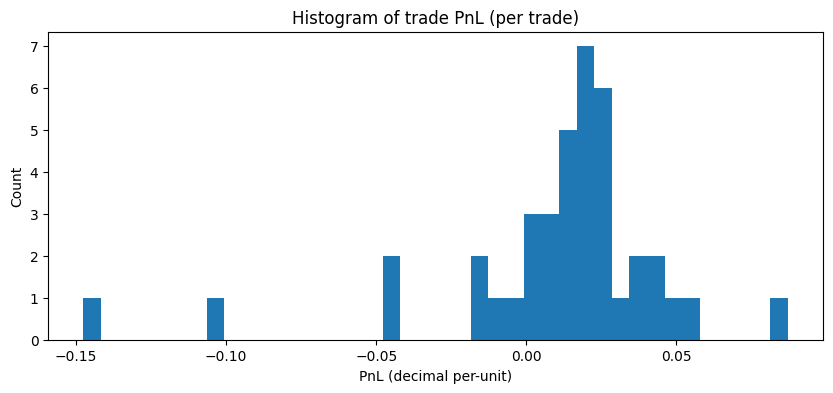

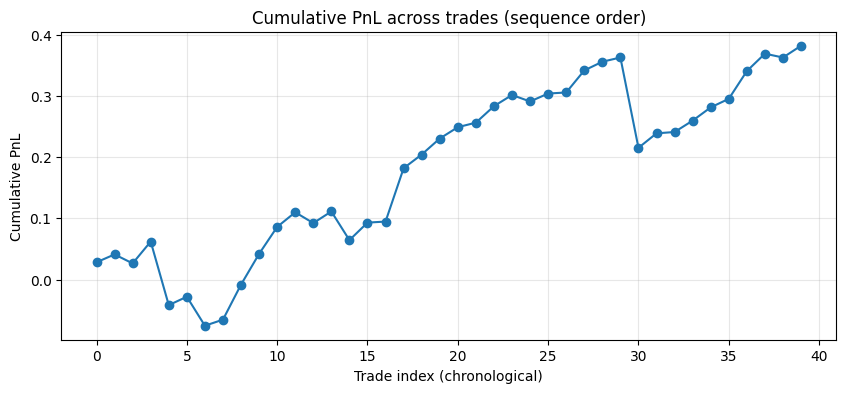

In [129]:
tl = pd.read_csv("trade_log.csv", parse_dates=["entry_date","exit_date"])
# basic counts & stats
total_trades = len(tl)
wins = (tl['trade_pnl'] > 0).sum()
losses = (tl['trade_pnl'] <= 0).sum()
win_rate = wins / total_trades if total_trades else np.nan
avg_pnl = tl['trade_pnl'].mean()
median_pnl = tl['trade_pnl'].median()
std_pnl = tl['trade_pnl'].std()
total_pnl = tl['trade_pnl'].sum()

# longest consecutive losses (in trades)
consec = 0
max_consec_loss = 0
for pnl in tl['trade_pnl']:
    if pnl <= 0:
        consec += 1
        max_consec_loss = max(max_consec_loss, consec)
    else:
        consec = 0

# avg pnl by entry z (bin)
tl['entry_z_bin'] = pd.cut(tl['entry_z'], bins=[-99,-3,-2.5,-2,-1.5,-1,0,1,1.5,2,2.5,3,99])
grouped = tl.groupby('entry_z_bin')['trade_pnl'].agg(['count','mean','median']).reset_index()

# prints
print("Trade log diagnostics")
print("---------------------")
print(f"Total trades: {total_trades}")
print(f"Wins: {wins}, Losses: {losses}, Win rate: {win_rate:.2%}")
print(f"Total PnL (sum of trades): {total_pnl:.4f}")
print(f"Avg PnL/trade: {avg_pnl:.4f}, Median: {median_pnl:.4f}, Std: {std_pnl:.4f}")
print(f"Longest streak of consecutive losing trades: {max_consec_loss}")

print("\nAvg PnL by entry z-bin (showing non-empty bins):")
print(grouped[grouped['count']>0].to_string(index=False))

# plots
plt.figure(figsize=(10,4))
plt.hist(tl['trade_pnl'], bins=40)
plt.title("Histogram of trade PnL (per trade)")
plt.xlabel("PnL (decimal per-unit)"); plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(tl['trade_pnl'].cumsum().values, marker='o', linestyle='-')
plt.title("Cumulative PnL across trades (sequence order)")
plt.xlabel("Trade index (chronological)"); plt.ylabel("Cumulative PnL")
plt.grid(alpha=0.3)
plt.show()

Trade duration stats
--------------------
Average trade length: 18.88 days
Median trade length:  14.50 days
Max trade length:     68 days
Shortest trade length:1 day(s)

Correlation between trade length and PnL: -0.82

Avg PnL by trade length bin:
  dur_bin  count      mean    median
   (0, 2]      2  0.020312  0.020312
   (2, 5]      6  0.044733  0.039311
  (5, 10]      5  0.028697  0.026907
 (10, 15]     10  0.020484  0.014082
 (15, 30]      8  0.009314  0.010327
(30, 999]      9 -0.038869 -0.017664


/tmp/ipykernel_4079/177588045.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = tl.groupby('dur_bin')['trade_pnl'].agg(['count','mean','median']).reset_index()


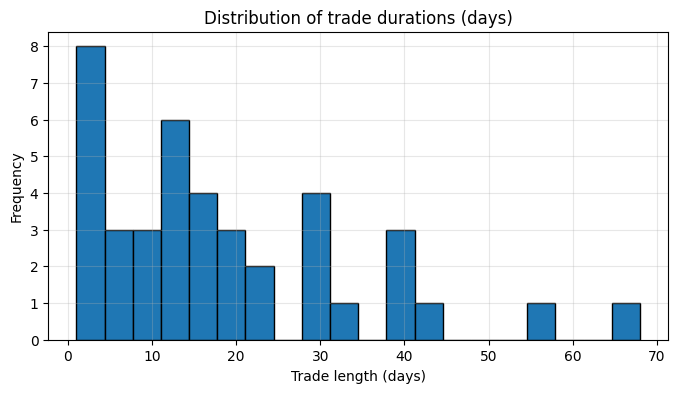

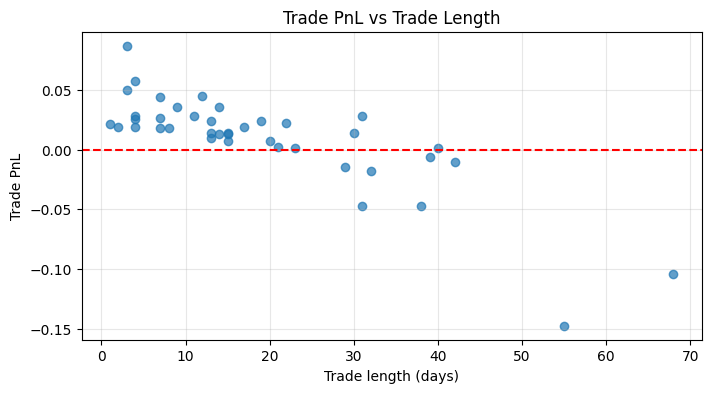

In [131]:
# Trade duration analysis
import pandas as pd
import matplotlib.pyplot as plt

tl = pd.read_csv("trade_log.csv", parse_dates=["entry_date","exit_date"])
tl['trade_length_days'] = (tl['exit_date'] - tl['entry_date']).dt.days

# basic stats
avg_len = tl['trade_length_days'].mean()
med_len = tl['trade_length_days'].median()
max_len = tl['trade_length_days'].max()
shortest = tl['trade_length_days'].min()

print("Trade duration stats")
print("--------------------")
print(f"Average trade length: {avg_len:.2f} days")
print(f"Median trade length:  {med_len:.2f} days")
print(f"Max trade length:     {max_len} days")
print(f"Shortest trade length:{shortest} day(s)")

# correlation between duration and PnL
corr = tl['trade_length_days'].corr(tl['trade_pnl'])
print(f"\nCorrelation between trade length and PnL: {corr:.2f}")

# group avg pnl by duration buckets
bins = [0,2,5,10,15,30,999]
tl['dur_bin'] = pd.cut(tl['trade_length_days'], bins=bins)
grouped = tl.groupby('dur_bin')['trade_pnl'].agg(['count','mean','median']).reset_index()
print("\nAvg PnL by trade length bin:")
print(grouped.to_string(index=False))

# plot histogram of trade lengths
plt.figure(figsize=(8,4))
plt.hist(tl['trade_length_days'], bins=20, edgecolor='black')
plt.title("Distribution of trade durations (days)")
plt.xlabel("Trade length (days)"); plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

# scatter: PnL vs duration
plt.figure(figsize=(8,4))
plt.scatter(tl['trade_length_days'], tl['trade_pnl'], alpha=0.7)
plt.title("Trade PnL vs Trade Length")
plt.xlabel("Trade length (days)"); plt.ylabel("Trade PnL")
plt.axhline(0, color='red', linestyle='--')
plt.grid(alpha=0.3)
plt.show()


# Turnover and capital usage

In [135]:
# Step C — Turnover and capital efficiency
import pandas as pd
import numpy as np

tl = pd.read_csv("trade_log.csv", parse_dates=["entry_date","exit_date"])

# basic trade frequency
years = (tl['exit_date'].max() - tl['entry_date'].min()).days / 365.25
trades_per_year = len(tl) / years

# total days in market (sum of trade durations)
total_days_in_market = tl['trade_length_days'].sum()
#  unique active days (approx capital utilization)
active_days = pd.Series(dtype=int)
for _, row in tl.iterrows():
    active_days = pd.concat([active_days, pd.Series(pd.date_range(row.entry_date, row.exit_date))])
active_days = active_days.dt.normalize().drop_duplicates()
utilization = len(active_days) / ((tl['exit_date'].max() - tl['entry_date'].min()).days)

# annualized turnover (number of round-trips per year)
turnover = trades_per_year

# capital efficiency: assuming 1 unit capital deployed whenever a position is open
# effective annualized return = CAGR / utilization
from math import pow

total_pnl = tl['trade_pnl'].sum()
cagr_nominal = pow(1 + total_pnl, 1/years) - 1 if years > 0 else np.nan
cagr_eff = cagr_nominal / utilization if utilization > 0 else np.nan

# --- print summary ---
print("Capital & Turnover Summary")
print("---------------------------")
print(f"Backtest span: {years:.2f} years")
print(f"Total trades: {len(tl)}  |  Trades per year: {trades_per_year:.2f}")
print(f"Total days in market (sum of all trade durations): {total_days_in_market}")
print(f"Unique active trading days: {len(active_days)}")
print(f"Capital utilization (fraction of time invested): {utilization:.2%}")
print(f"Nominal CAGR (from total PnL): {cagr_nominal:.2%}")
print(f"Effective CAGR (scaled by utilization): {cagr_eff:.2%}")


Capital & Turnover Summary
---------------------------
Backtest span: 6.57 years
Total trades: 40  |  Trades per year: 6.09
Total days in market (sum of all trade durations): 755
Unique active trading days: 795
Capital utilization (fraction of time invested): 33.15%
Nominal CAGR (from total PnL): 5.05%
Effective CAGR (scaled by utilization): 15.24%


/tmp/ipykernel_4079/1048683875.py:16: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  active_days = pd.concat([active_days, pd.Series(pd.date_range(row.entry_date, row.exit_date))])


# Performance report summary

In [153]:
import pandas as pd
import numpy as np

# --- reload any key series (optional safety) ---
equity = pd.read_csv("equity_net_series.csv", index_col=0, parse_dates=True)
if isinstance(equity, pd.DataFrame) and equity.shape[1] == 1:
    equity = equity.iloc[:,0]
tl = pd.read_csv("trade_log.csv", parse_dates=["entry_date","exit_date"])

# --- core metrics ---
total_ret = float(equity.iloc[-1])
years = (equity.index[-1] - equity.index[0]).days / 365.25
cagr = (1 + total_ret)**(1/years) - 1
daily_ret = equity.diff().fillna(0)
ann_vol = daily_ret.std() * np.sqrt(252)
ann_ret = daily_ret.mean() * 252
sharpe = ann_ret / ann_vol if ann_vol != 0 else np.nan
cummax = equity.cummax()
drawdown = equity - cummax
max_dd = drawdown.min()
dd_pct = (max_dd / cummax.max()) if cummax.max() != 0 else np.nan

# --- trade metrics ---
wins = (tl['trade_pnl'] > 0).sum()
losses = (tl['trade_pnl'] <= 0).sum()
win_rate = wins / len(tl) if len(tl) else np.nan
avg_pnl = tl['trade_pnl'].mean()
avg_len = tl['trade_length_days'].mean()
trades_per_year = len(tl) / years

# --- capital efficiency metrics (reuse Step C logic) ---
active_days = pd.Series(dtype=int)
for _, row in tl.iterrows():
    active_days = pd.concat([active_days, pd.Series(pd.date_range(row.entry_date, row.exit_date))])
active_days = active_days.dt.normalize().drop_duplicates()
utilization = len(active_days) / ((tl['exit_date'].max() - tl['entry_date'].min()).days)
cagr_eff = cagr / utilization if utilization > 0 else np.nan

# --- compile all into DataFrame ---
summary = pd.DataFrame({
    "Metric": [
        "Total Return (decimal)", "Years", "CAGR", "Annualized Return", "Annualized Volatility",
        "Sharpe Ratio", "Max Drawdown (abs)", "Max Drawdown (%)",
        "Total Trades", "Win Rate", "Avg PnL per Trade", "Avg Trade Length (days)",
        "Trades per Year", "Capital Utilization", "Effective CAGR (scaled)"
    ],
    "Value": [
        total_ret, years, cagr, ann_ret, ann_vol, sharpe,
        max_dd, dd_pct, len(tl), win_rate, avg_pnl, avg_len,
        trades_per_year, utilization, cagr_eff
    ]
})

# format nicely
summary["Value"] = summary["Value"].apply(lambda x: f"{x:.4f}" if isinstance(x, (float, np.floating)) else str(x))
summary.to_csv("performance_report.csv", index=False)

display(summary)

/tmp/ipykernel_4079/659951985.py:34: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  active_days = pd.concat([active_days, pd.Series(pd.date_range(row.entry_date, row.exit_date))])


,Metric,Value
0,Total Return (decimal),0.6361
1,Years,7.0007
2,CAGR,0.0729
3,Annualized Return,0.0927
4,Annualized Volatility,0.1481
5,Sharpe Ratio,0.6254
6,Max Drawdown (abs),-0.2594
7,Max Drawdown (%),-0.4029
8,Total Trades,40.0000
9,Win Rate,0.8000
